In [1]:
!pip install lightgbm

In [2]:
!pip install catboost

In [3]:
!pip install optuna

In [4]:
# импорт
import numpy as np
import pandas as pd

import json
import yaml
import joblib

from sklearn.model_selection import train_test_split, KFold

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm_notebook
import optuna
from optuna.visualization.matplotlib import plot_param_importances

import warnings
warnings.filterwarnings("ignore")

# Подбор модели для задачи регрессии

Модель будет предсказывать рейтинг книги на основе её признакового описания:
- **authors**: автор/авторы книги
- **language_code**: язык книги
- **num_pages**: количество страниц
- **ratings_count**: количество оценок книги
- **publication_year**: дата публикации
- **century**: век публикации
- **publisher**: издательство
- **genres**: жанр

Для предсказания будет использоваться BoostingRegressor, как алгоритм призванный снижать ошибку за счёт уменьшения смещения, что акутально для задачи регрессии (предсказывания определённого числа - рейтинга). Так как датасет содержит категориальные даннные, рассмотрим модели LightGBM и Catboost, которые умеют обрабатывать категориальные признаки.

## Препроцессинг данных 

In [5]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)


preproc = config['preprocessing']
training = config['train']

In [6]:
# параметры препроцессинга
preproc

{'change_type_columns': {'authors': 'category',
  'language_code': 'category',
  'publisher': 'category',
  'genre': 'category',
  'publication_year': 'int64',
  'century': 'category'},
 'date_transform': {'publication_date': 'publication_year'},
 'copy': {'publication_year': 'century'},
 'map_bins_columns': {'century': [[1950, 2000], [20, 20.5, 21]]},
 'drop_columns': ['bookID',
  'isbn',
  'isbn13',
  'title',
  'publication_date',
  'text_reviews_count'],
 'train_path': '../data/processed/books_processed.csv',
 'unique_values_path': '../data/processed/unique_values.json',
 'test_size': 0.25,
 'target_column': 'average_rating',
 'random_state': 10,
 'train_path_proc': '../data/processed/train.csv',
 'test_path_proc': '../data/processed/test.csv',
 'raw_data_path': '../data/raw/books.csv'}

In [7]:
# параметры train
training

{'n_trials': 3,
 'n_folds': 5,
 'random_state': 10,
 'val_size': 0.16,
 'model_path': '../models/model.joblib',
 'study_path': '../models/study.joblib',
 'metrics_path': '../report/metrics.json',
 'params_path': '../report/best_params.json'}

In [8]:
# чтение данных
data = pd.read_csv(preproc['train_path'])
data.head()

,authors,average_rating,language_code,num_pages,ratings_count,publisher,genre,publication_year,century
0,J.K. Rowling,4.42,eng,352,6333,Scholastic,Fantasy,2003,21
1,W. Frederick Zimmerman,3.74,en-US,152,19,Nimble Books,Fiction,2005,21
2,Douglas Adams,4.38,eng,815,3628,Gramercy Books,Science Fiction,2005,21
3,Douglas Adams,4.22,eng,215,4930,Crown,Science Fiction,2004,21
4,Douglas Adams/Stephen Fry,4.22,eng,6,1266,Random House Audio,Science Fiction,2005,21


In [9]:
# проверка типа данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   authors           9953 non-null   object 
 1   average_rating    9953 non-null   float64
 2   language_code     9953 non-null   object 
 3   num_pages         9953 non-null   int64  
 4   ratings_count     9953 non-null   int64  
 5   publisher         9953 non-null   object 
 6   genre             9953 non-null   object 
 7   publication_year  9953 non-null   int64  
 8   century           9953 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 699.9+ KB


In [10]:
def transform_types(data: pd.DataFrame, change_type_columns: dict) -> pd.DataFrame:
    """
    Изменение типа данных для признаков
    param data: датасет
    param change_type_columns: словарь с признаками и типами данных
    """
    
    return data.astype(change_type_columns, errors="ignore")

In [11]:
change_type_columns = preproc['change_type_columns']
data = transform_types(data=data, change_type_columns=change_type_columns)

In [12]:
preproc['target_column']

'average_rating'

In [13]:
# разбиение датасета на выборки для train и test
X = data.drop(columns=[preproc['target_column']], axis=1)
y = data[preproc['target_column']]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=preproc['test_size'],
    random_state=preproc['random_state'])

In [14]:
# финальная проверка признаков перед обучением
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 5975 to 1289
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   authors           7464 non-null   category
 1   language_code     7464 non-null   category
 2   num_pages         7464 non-null   int64   
 3   ratings_count     7464 non-null   int64   
 4   publisher         7464 non-null   category
 5   genre             7464 non-null   category
 6   publication_year  7464 non-null   int64   
 7   century           7464 non-null   category
dtypes: category(5), int64(3)
memory usage: 543.5 KB


In [15]:
X_train.to_csv(preproc['train_path_proc'], index=False)

In [16]:
X_test.to_csv(preproc['test_path_proc'], index=False)

# Train

### Метрики регрессии 

In [17]:
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100



In [18]:
def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100



In [19]:
def get_metrics_regression(y_test: np.ndarray,
                           y_pred: np.ndarray,
                           X_test: np.ndarray,
                           name: str = None):
    """Генерация таблицы с метриками для задачи регрессии"""
    
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['R2'] = r2_score(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)
    
    return df_metrics



In [20]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на переобучение для регрессии
    """
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')
    
    

### LGBM Baseline

In [21]:
lgbm = LGBMRegressor(random_state=training['random_state'])
lgbm.fit(X_train, y_train)

LGBMRegressor(random_state=10)

In [22]:
y_pred_lgbm = lgbm.predict(X_test)

model_metrics = get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_lgbm,
                           X_test=X_test,
                           name='LGBM_base_test')

model_metrics

,model,MAE,MSE,R2,MAPE_%,WAPE_%
0,LGBM_base_test,0.208069,0.076819,0.128265,5.45462,5.292585


In [23]:
check_overfitting(lgbm, X_train, y_train, 
                  X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.169
mean_absolute_error test: 0.208
delta = 18.9 %


MAE = 0.2 соизмеримо с диапазоном изменения оценки рейтинга (от 0 до 5). По относительным метрикам (MAPE, WAPE) выявлено отклонение в 5% предсказания от истинного рейтинга. Несмотря на то, что метрики выглядят убедительно, чтобы выбрать LightGBM, вызывает сомнения малый коэффициент детегминации.

### CatBoost baseline 

In [24]:
cat_features = X.select_dtypes('category').columns.tolist()

cat = CatBoostRegressor(allow_writing_files=False,
                        random_state=training['random_state'],
                        eval_metric="MAE",
                        cat_features=cat_features)
cat.fit(X_train,
        y_train,
        verbose=False,
        early_stopping_rounds=100)

y_pred_cat = cat.predict(X_test)

In [25]:
model_metrics = pd.concat([
    model_metrics,
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_cat,
                           X_test=X_test,
                           name='CatBoost_base_test')
])
model_metrics

,model,MAE,MSE,R2,MAPE_%,WAPE_%
0,LGBM_base_test,0.208069,0.076819,0.128265,5.454620,5.292585
0,CatBoost_base_test,0.196060,0.069811,0.207791,5.148828,4.987110


In [26]:
check_overfitting(cat, X_train, y_train, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.134
mean_absolute_error test: 0.196
delta = 31.5 %


У Catboost baseline все метрики лучше, чем у LGBM baseline: MAE, MSE, MAPE, WAPE немного уменьшились, a R2 коэффициент увеличился в два раза. (Однако, всё равно далёк от 1). Также, если смотреть переобучение модели, для Catboost оно больше, чем для LGBM (32% vs. 20%), но mae на test дял catboost сопоставиа с mae на train для lgbm. В итоге, выбираем catboost.

# Tuning catboost 

In [27]:
cat_tuning_metrics = get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_cat,
                           X_test=X_test,
                           name='CatBoost_baseline')
cat_tuning_metrics

,model,MAE,MSE,R2,MAPE_%,WAPE_%
0,CatBoost_baseline,0.19606,0.069811,0.207791,5.148828,4.98711


In [ ]:
for num in tqdm_notebook([500, 800, 1200, 1500]):
    cat = CatBoostRegressor(allow_writing_files=False, 
                            random_state=training['random_state'],
                            iterations=num,
                            eval_metric="MAE",
                            cat_features=cat_features,
                            verbose=False)
    cat.fit(X_train, y_train)
    y_pred = cat.predict(X_test)

    result = get_metrics_regression(y_test, y_pred, X_test)
    print(f"estimators_num = {num}, MAE = {round(result['MAE'].values[0], 6)}")

Количество базовых алгоритмов в catboost baseline = 1000. Mae для этого случая = 0.196321. Для дальнейшего подбора параметров выберем модель с числом деревьев = 800. Этот выбор объясняется уменьшением метрики относительно baseline и уменьшением числа алгоритмов в бустинге, что ускорит обучение модели.

### Random Optuna 

In [44]:
def objective_cat_rand(trial, X, y, n_folds, random_state, cat_feat):
    
    params = {"random_state": trial.suggest_categorical("random_state", [random_state]),
        "cat_features": trial.suggest_categorical("cat_features", [cat_feat]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["MAE"]), 
        
        "iterations": trial.suggest_categorical("iterations", [800]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 4, 8, step=2),
        "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2), 
        'random_strength': trial.suggest_uniform('random_strength', 0.5, 25),
        'border_count': trial.suggest_categorical('border_count', [32]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ['Plain'])       
        
      }  
        
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 100)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float(
            "subsample", 0.1, 1, log=True)
        
    
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(n_folds)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [45]:
study_cat_rand = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Catoost_random_tuning")
func = lambda trial: objective_cat_rand(trial,
                                   X_train,
                                   y_train,
                                   n_folds=training['n_folds'],
                                   random_state=training['random_state'],
                                   cat_feat=cat_features)
study_cat_rand.optimize(func, n_trials=training['n_trials'], show_progress_bar=True)

[I 2024-09-03 21:42:13,352] A new study created in memory with name: Catoost_random_tuning


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2024-09-03 21:42:54,131] Trial 0 finished with value: 0.19517193999911697 and parameters: {'random_state': 10, 'cat_features': ['authors', 'language_code', 'publisher', 'genre', 'century'], 'eval_metric': 'MAE', 'iterations': 800, 'learning_rate': 0.06537884528223845, 'max_depth': 4, 'l2_leaf_reg': 15.218776355368787, 'random_strength': 4.373408710999925, 'border_count': 32, 'bootstrap_type': 'No', 'grow_policy': 'Depthwise', 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.19517193999911697.
[I 2024-09-03 21:44:47,571] Trial 1 finished with value: 0.19506777747896784 and parameters: {'random_state': 10, 'cat_features': ['authors', 'language_code', 'publisher', 'genre', 'century'], 'eval_metric': 'MAE', 'iterations': 800, 'learning_rate': 0.037601417543820216, 'max_depth': 8, 'l2_leaf_reg': 74.7986349274914, 'random_strength': 20.25708710557701, 'border_count': 32, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Depthwise', 'boosting_type': 'Plain', 'subsample': 0.88047857107

In [46]:
print(f"\tBest value (mae): {study_cat_rand.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_cat_rand.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (mae): 0.19506778
	Best params:
		random_state: 10
		cat_features: ['authors', 'language_code', 'publisher', 'genre', 'century']
		eval_metric: MAE
		iterations: 800
		learning_rate: 0.037601417543820216
		max_depth: 8
		l2_leaf_reg: 74.7986349274914
		random_strength: 20.25708710557701
		border_count: 32
		bootstrap_type: Bernoulli
		grow_policy: Depthwise
		boosting_type: Plain
		subsample: 0.880478571079749


<AxesSubplot:title={'left':'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

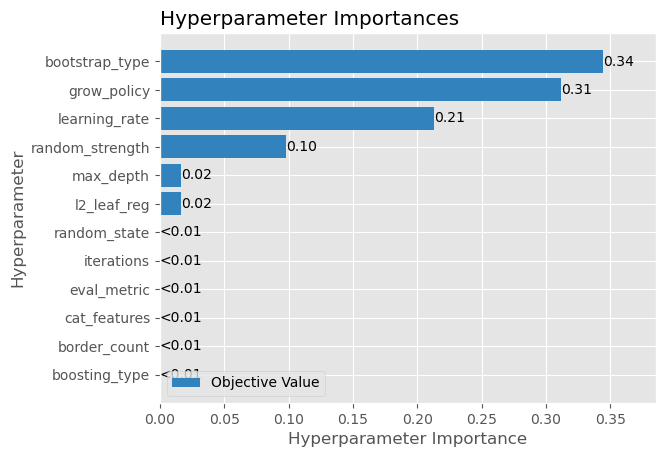

In [47]:
plot_param_importances(study_cat_rand)

Заметно уменьшение метрики (mae). Для baseline_mae = 0.196321, после подбора параметров tuning_mae = 0.19543642. Улучшение метрики на 0.45%.

## Consequental search

In [60]:
def objective_cat(trial, X, y, n_folds, random_state, cat_feat):
    
    params = {"random_state": trial.suggest_categorical("random_state", [random_state]),
        "cat_features": trial.suggest_categorical("cat_features", [cat_feat]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["MAE"]), 
        
        "iterations": trial.suggest_categorical("iterations", [800]),
        #"learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.045358]),
        #"max_depth": trial.suggest_int("max_depth", 4, 16, step=2), default=6
        "max_depth": trial.suggest_categorical("max_depth", [6]),
        #"l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2), default=3
        "l2_leaf_reg": trial.suggest_categorical("l2_leaf_reg", [4.3139]),
        #'random_strength': trial.suggest_uniform('random_strength', 0.5, 25), default=1
        'random_strength': trial.suggest_categorical('random_strength', [9.529764]),
        'border_count': trial.suggest_categorical('border_count', [254]),
        'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["MVS"]),
        'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ['Plain'])       
        
      }
        
    
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(n_folds)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [61]:
study_cat = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Catboost_consequent_tuning")
func = lambda trial: objective_cat(trial,
                                   X_train,
                                   y_train,
                                   n_folds=training['n_folds'],
                                   random_state=training['random_state'],
                                   cat_feat=cat_features)
study_cat.optimize(func, n_trials=1, show_progress_bar=True)

[I 2024-09-03 21:51:33,699] A new study created in memory with name: Catboost_consequent_tuning


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-09-03 21:53:01,865] Trial 0 finished with value: 0.1942710524949348 and parameters: {'random_state': 10, 'cat_features': ['authors', 'language_code', 'publisher', 'genre', 'century'], 'eval_metric': 'MAE', 'iterations': 800, 'learning_rate': 0.045358, 'max_depth': 6, 'l2_leaf_reg': 4.3139, 'random_strength': 9.529764, 'border_count': 254, 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.1942710524949348.


In [62]:
print(f"\tBest value (mae): {study_cat.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_cat.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (mae): 0.19427105
	Best params:
		random_state: 10
		cat_features: ['authors', 'language_code', 'publisher', 'genre', 'century']
		eval_metric: MAE
		iterations: 800
		learning_rate: 0.045358
		max_depth: 6
		l2_leaf_reg: 4.3139
		random_strength: 9.529764
		border_count: 254
		bootstrap_type: MVS
		grow_policy: SymmetricTree
		boosting_type: Plain


Путём последовательного подбора удалось уменьшить mae на 1% относительно baseline и на 0.6% относительно результатов optuna. 

# Обучение с лучшими параметрами

In [63]:
# разбиение на валидационную выборку
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=training['test_size'],
                                                    random_state=training['random_state'])
eval_set = [(X_val, y_val)]

In [64]:
# обучение с лучшими параметрами
cat_opt = CatBoostRegressor(**study_cat.best_params)
cat_opt.fit(X_train,
               y_train,
               cat_features=cat_features,
               verbose=False,
               eval_set=eval_set)

y_pred_opt = cat_opt.predict(X_test)

In [65]:
cat_tuning_metrics = pd.concat([
    cat_tuning_metrics,
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_opt,
                           X_test=X_test,
                           name='CatBoost_tuned')
])

cat_tuning_metrics

,model,MAE,MSE,R2,MAPE_%,WAPE_%
0,CatBoost_baseline,0.196060,0.069811,0.207791,5.148828,4.987110
0,CatBoost_tuned,0.195987,0.069777,0.208171,5.150193,4.985266
0,CatBoost_tuned,0.195778,0.069302,0.213567,5.140309,4.979935


In [66]:
check_overfitting(cat_opt, X_train, y_train, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.135
mean_absolute_error test: 0.196
delta = 30.8 %


# Сохранение модели

In [67]:
training['model_path']

'../models/model.joblib'

In [68]:
model_path = training['model_path']

# сохранение модели
joblib.dump(cat_opt, model_path)

['../models/model.joblib']

In [69]:
training['metrics_path']

'../report/metrics.json'

In [72]:
metrics_path = training['metrics_path']

# сохранение метрик
metrics = get_metrics_regression(y_test, y_pred_opt, X_test, 'Catboost')
with open(metrics_path, 'w') as file:
    metrics.to_json(file)

In [73]:
# проверяем наличие метрик
with open(metrics_path) as json_file:
    metrics = json.load(json_file)
metrics

{'model': {'0': 'Catboost'},
 'MAE': {'0': 0.1957776761},
 'MSE': {'0': 0.0693018516},
 'R2': {'0': 0.2135665134},
 'MAPE_%': {'0': 5.1403094335},
 'WAPE_%': {'0': 4.9799351247}}